In [29]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import astroML
from astroML.stats import sigmaG
import pandas as pd
import seaborn as sns
import dynesty

In [30]:
# show plots inline in the notebook
%matplotlib inline

import numpy as np                  # import numpy
from time import time               # use for timing functions

# useful modules!
import os
import sys

# make the plots look a bit nicer with some defaults
from matplotlib import pyplot as pl # import pyplot from matplotlib
import matplotlib as mpl
rcparams = {}
rcparams['axes.linewidth'] = 0.5
rcparams['font.family'] = 'serif'
rcparams['font.size'] = 22
rcparams['legend.fontsize'] = 16
rcparams['mathtext.fontset'] = "stix"

# functions for plotting posteriors
import corner
from scipy.stats import gaussian_kde

In [31]:
# # set the true values of the model parameters for creating the data
# m = 3.5 # gradient of the line
# c = 1.2 # y-intercept of the line

# # set the "predictor variable"/abscissa
# M = 50
# xmin = 0.
# xmax = 10.
# stepsize = (xmax - xmin) / M
# x = np.arange(xmin, xmax, stepsize)

# # define the model function
# def straight_line(x, m, c):
#     """
#     A straight line model: y = m*x + c
    
#     Args:
#         x (list): a set of abscissa points at which the model is defined
#         m (float): the gradient of the line
#         c (float): the y-intercept of the line
#     """

#     return m * x + c

# # seed our random number generator, so we have reproducible data
# np.random.seed(sum([ord(v) for v in 'samplers']))

# # create the data - the model plus Gaussian noise
# sigma = 2.0  # standard deviation of the noise
# data = straight_line(x, m, c) + np.random.normal(scale=sigma, size=M)

# # plot the data
# mpl.rcParams.update(rcparams) # update plot parameters
# fig, ax = pl.subplots(figsize=(9,6))
# ax.plot(x, data, 'bo', alpha=0.5, label='data')
# ax.plot(x, straight_line(x, m, c), 'r-', lw=2, label='model')
# ax.legend()
# ax.set_xlim([xmin, xmax])
# ax.set_xlabel(r'$x$');

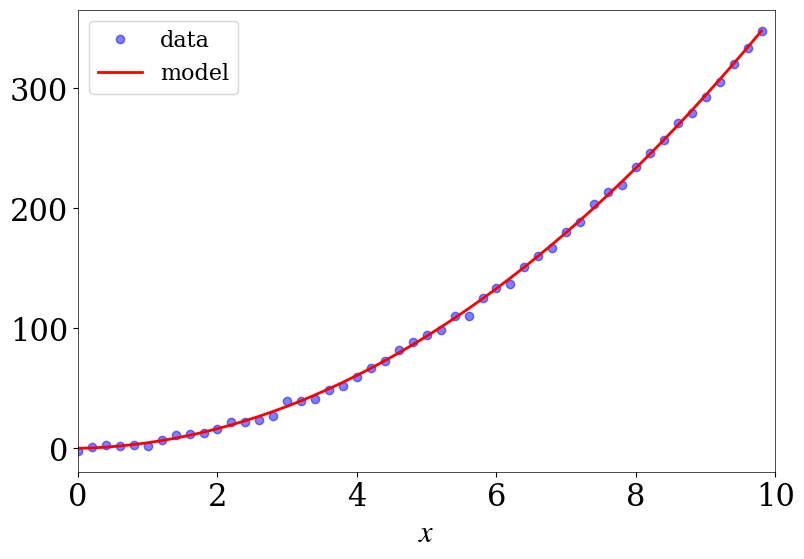

In [32]:
# set the true values of the model parameters for creating the data
m = 3.5 # gradient of the line
c = 1.2 # y-intercept of the line
theta = [m, c, 0]
# set the "predictor variable"/abscissa
M = 50
xmin = 0.
xmax = 10.
stepsize = (xmax - xmin) / M
x = np.arange(xmin, xmax, stepsize)

# define the model function
def quadratic_curve(x, theta):
    """
    A quadratic curve model: y = theta[0]*x**2 + theta[1]*x + theta[2]
    
    Args:
        x (list): a set of abscissa points at which the model is defined
        theta (list): a list of model parameters
    """

    return theta[0] * x**2 + theta[1] * x + theta[2]

# seed our random number generator, so we have reproducible data
np.random.seed(sum([ord(v) for v in 'samplers']))

# create the data - the model plus Gaussian noise
sigma = 2.0  # standard deviation of the noise
data = quadratic_curve(x, theta) + np.random.normal(scale=sigma, size=M)

# plot the data
mpl.rcParams.update(rcparams) # update plot parameters
fig, ax = pl.subplots(figsize=(9,6))
ax.plot(x, data, 'bo', alpha=0.5, label='data')
ax.plot(x, quadratic_curve(x, theta), 'r-', lw=2, label='model')
ax.legend()
ax.set_xlim([xmin, xmax])
ax.set_xlabel(r'$x$');

In [33]:
# import the inverse error function from scipy
from scipy.special import ndtri

def prior_transform(theta):
    """
    A function defining the tranform between the parameterisation in the unit hypercube
    to the true parameters.

    Args:
        theta (tuple): a tuple containing the parameters.
        
    Returns:
        tuple: a new tuple or array with the transformed parameters.
    """

    mprime, cprime, val = theta # unpack the parameters (in their unit hypercube form)

    cmin = -10.  # lower bound on uniform prior on c
    cmax = 10.   # upper bound on uniform prior on c
    val_min = -10.  # lower bound on uniform prior on val
    val_max = 10.   # upper bound on uniform prior on val
    mmu = 0.     # mean of Gaussian prior on m
    msigma = 10. # standard deviation of Gaussian prior on m

    m = mmu + msigma*ndtri(mprime) # convert back to m
    c = cprime*(cmax-cmin) + cmin  # convert back to c
    val = val*(val_max-val_min) + val_min  # convert back to val
    return (m, c, val)

# set the natural logarithm of 2pi, so that it doesn't have to be recalculated
LN2PI = np.log(2. * np.pi)
LNSIGMA = np.log(sigma) # natural log of the data noise standard deviation


def loglikelihood_dynesty(theta):
    """
    The log-likelihood function.
    """

    m, c, val = theta # unpack the parameters

    # normalisation
    norm = -0.5 * M * LN2PI - M * LNSIGMA

    # chi-squared (data, sigma and x are global variables defined early on in this notebook)
    chisq = np.sum(((data-quadratic_curve(x, theta))/sigma)**2)

    return norm - 0.5 * chisq

In [34]:
# import dynesty
import dynesty

print('dynesty version: {}'.format(dynesty.__version__))

nlive = 1024      # number of live points
bound = 'multi'   # use MutliNest algorithm for bounds
ndims = 3         # two parameters
sample = 'unif'   # uniform sampling
tol = 0.1         # the stopping criterion

from dynesty import NestedSampler

sampler = NestedSampler(loglikelihood_dynesty, prior_transform, ndims,
                        bound=bound, sample=sample, nlive=nlive)

t0 = time()
sampler.run_nested(dlogz=tol, print_progress=True) # don't output progress bar
t1 = time()

timedynesty = (t1-t0)

print("Time taken to run 'dynesty' (in static mode) is {} seconds".format(timedynesty))

dynesty version: 2.1.0


16099it [00:33, 484.86it/s, +1024 | bound: 16 | nc: 1 | ncall: 60486 | eff(%): 28.797 | loglstar:   -inf < -108.582 <    inf | logz: -121.956 +/-  0.109 | dlogz:  0.000 >  0.100] 

Time taken to run 'dynesty' (in static mode) is 33.20732808113098 seconds


In [35]:
res = sampler.results # get results dictionary from sampler

logZdynesty = res.logz[-1]        # value of logZ
logZerrdynesty = res.logzerr[-1]  # estimate of the statistcal uncertainty on logZ

print("log(Z) = {} ± {}".format(logZdynesty, logZerrdynesty))

log(Z) = -121.95591372341998 ± 0.1370669848198888


In [36]:
print(res.summary())

Summary
nlive: 1024
niter: 16099
ncall: 59462
eff(%): 28.797
logz: -121.956 +/-  0.137
None
